#### Preparing data
Run the next cells to download and prepare the datasets and util functions.

In [7]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [8]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [9]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [10]:
if download_data:
    unzip_leaf_dataset()

#### Notebook start

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from init import dataset_dir

from skimage import io
from skimage.transform import resize

See the files in data_dir, You have to see two files and one folder: `test.csv`, `images`, `train.csv`

In [12]:
os.listdir(dataset_dir)

['resize_image',
 'center_resize_image',
 'submissions',
 'test.csv',
 'images',
 'shapes.csv',
 'train.csv']

# Features

In [5]:
train = pd.read_csv(dataset_dir+"/train.csv")
test = pd.read_csv(dataset_dir+"/test.csv")

In [6]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [7]:
train.shape, test.shape

((990, 194), (594, 193))

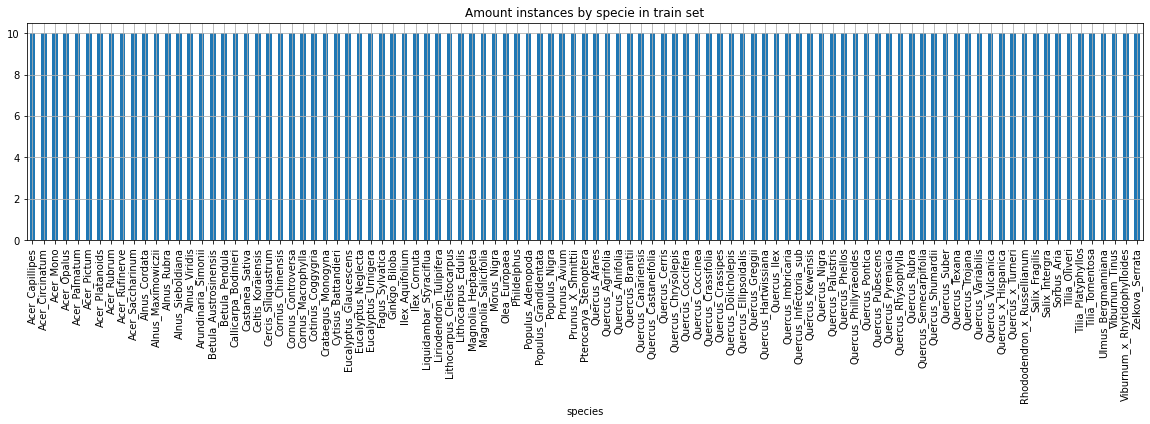

In [8]:
plt.figure()
train.id.groupby(train.species).count().plot.bar(figsize=(20, 4))
plt.title("Amount instances by specie in train set")
plt.grid()

In [9]:
num_classes = train.species.value_counts().shape[0]
print("There are {} classes for the classification task.".format(num_classes))

There are 99 classes for the classification task.


In [10]:
features = [i for i in train.columns if i not in ["species", "id"]]
len(features)

192

In [11]:
species = train.species.value_counts().index.tolist()
species = {species[i]:i for i in range(len(species))}

We can convert the species column to a numeric vector.

In [12]:
put_class = lambda x:species[x]
target = train.species.apply(put_class).values
len(target)

990

In [13]:
fs = features[::3]

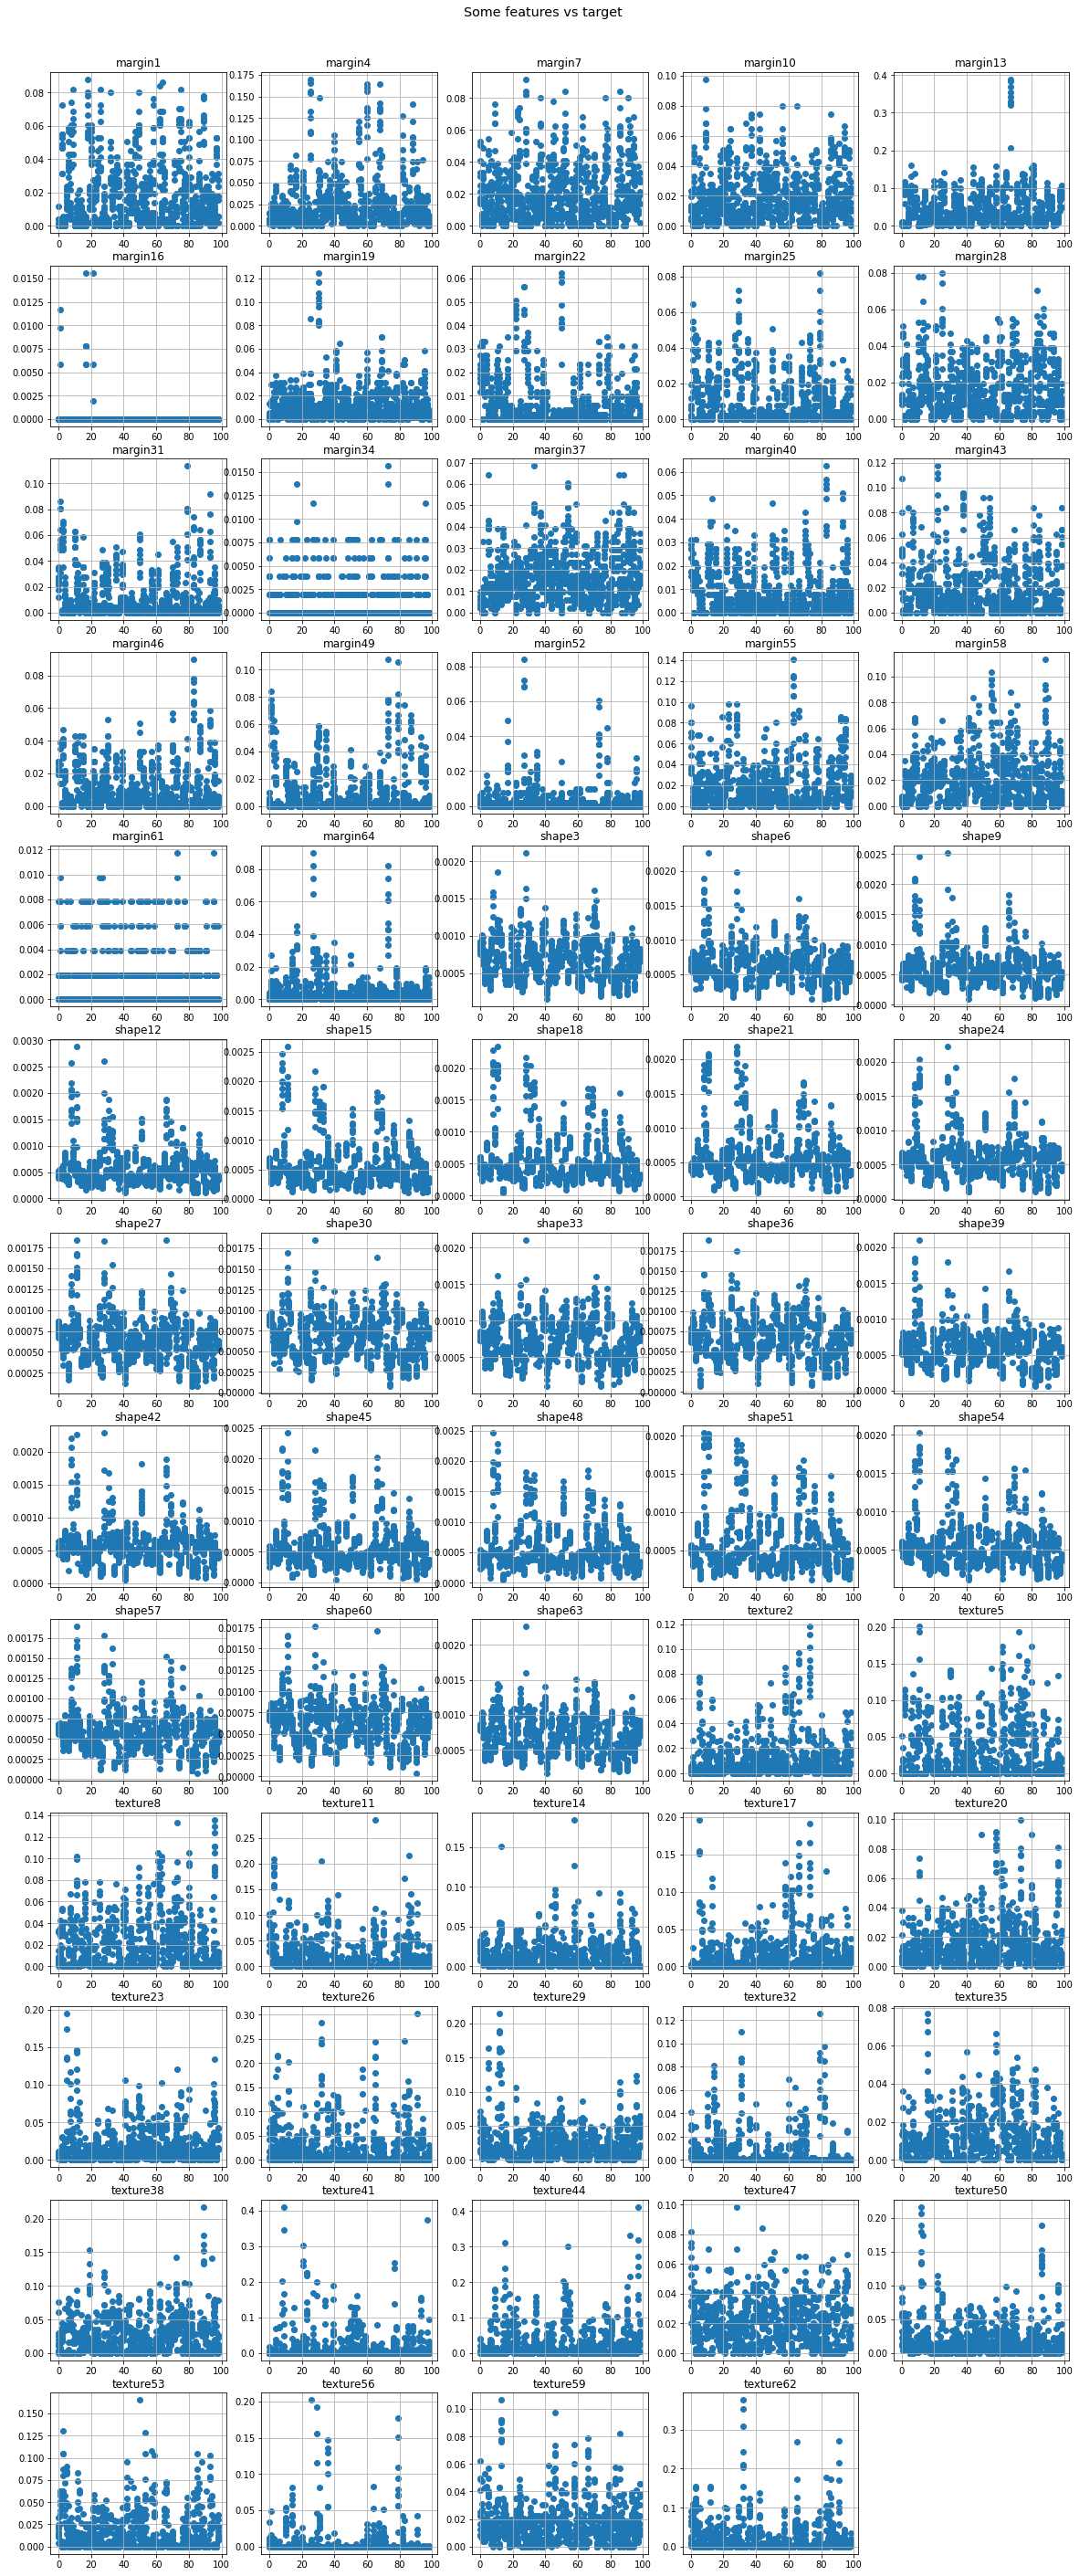

In [14]:
ncols = 5
nrows = int(len(fs)/ncols) + 1
plt.figure(figsize=(20, ncols*10))
st = plt.suptitle("Some features vs target", fontsize="x-large")

for n, feature in enumerate(fs):
    plt.subplot(nrows, ncols, n+1)
    plt.scatter(target, train[feature].values)
    plt.grid()
    plt.title(feature)
st.set_y(0.9)
plt.show()

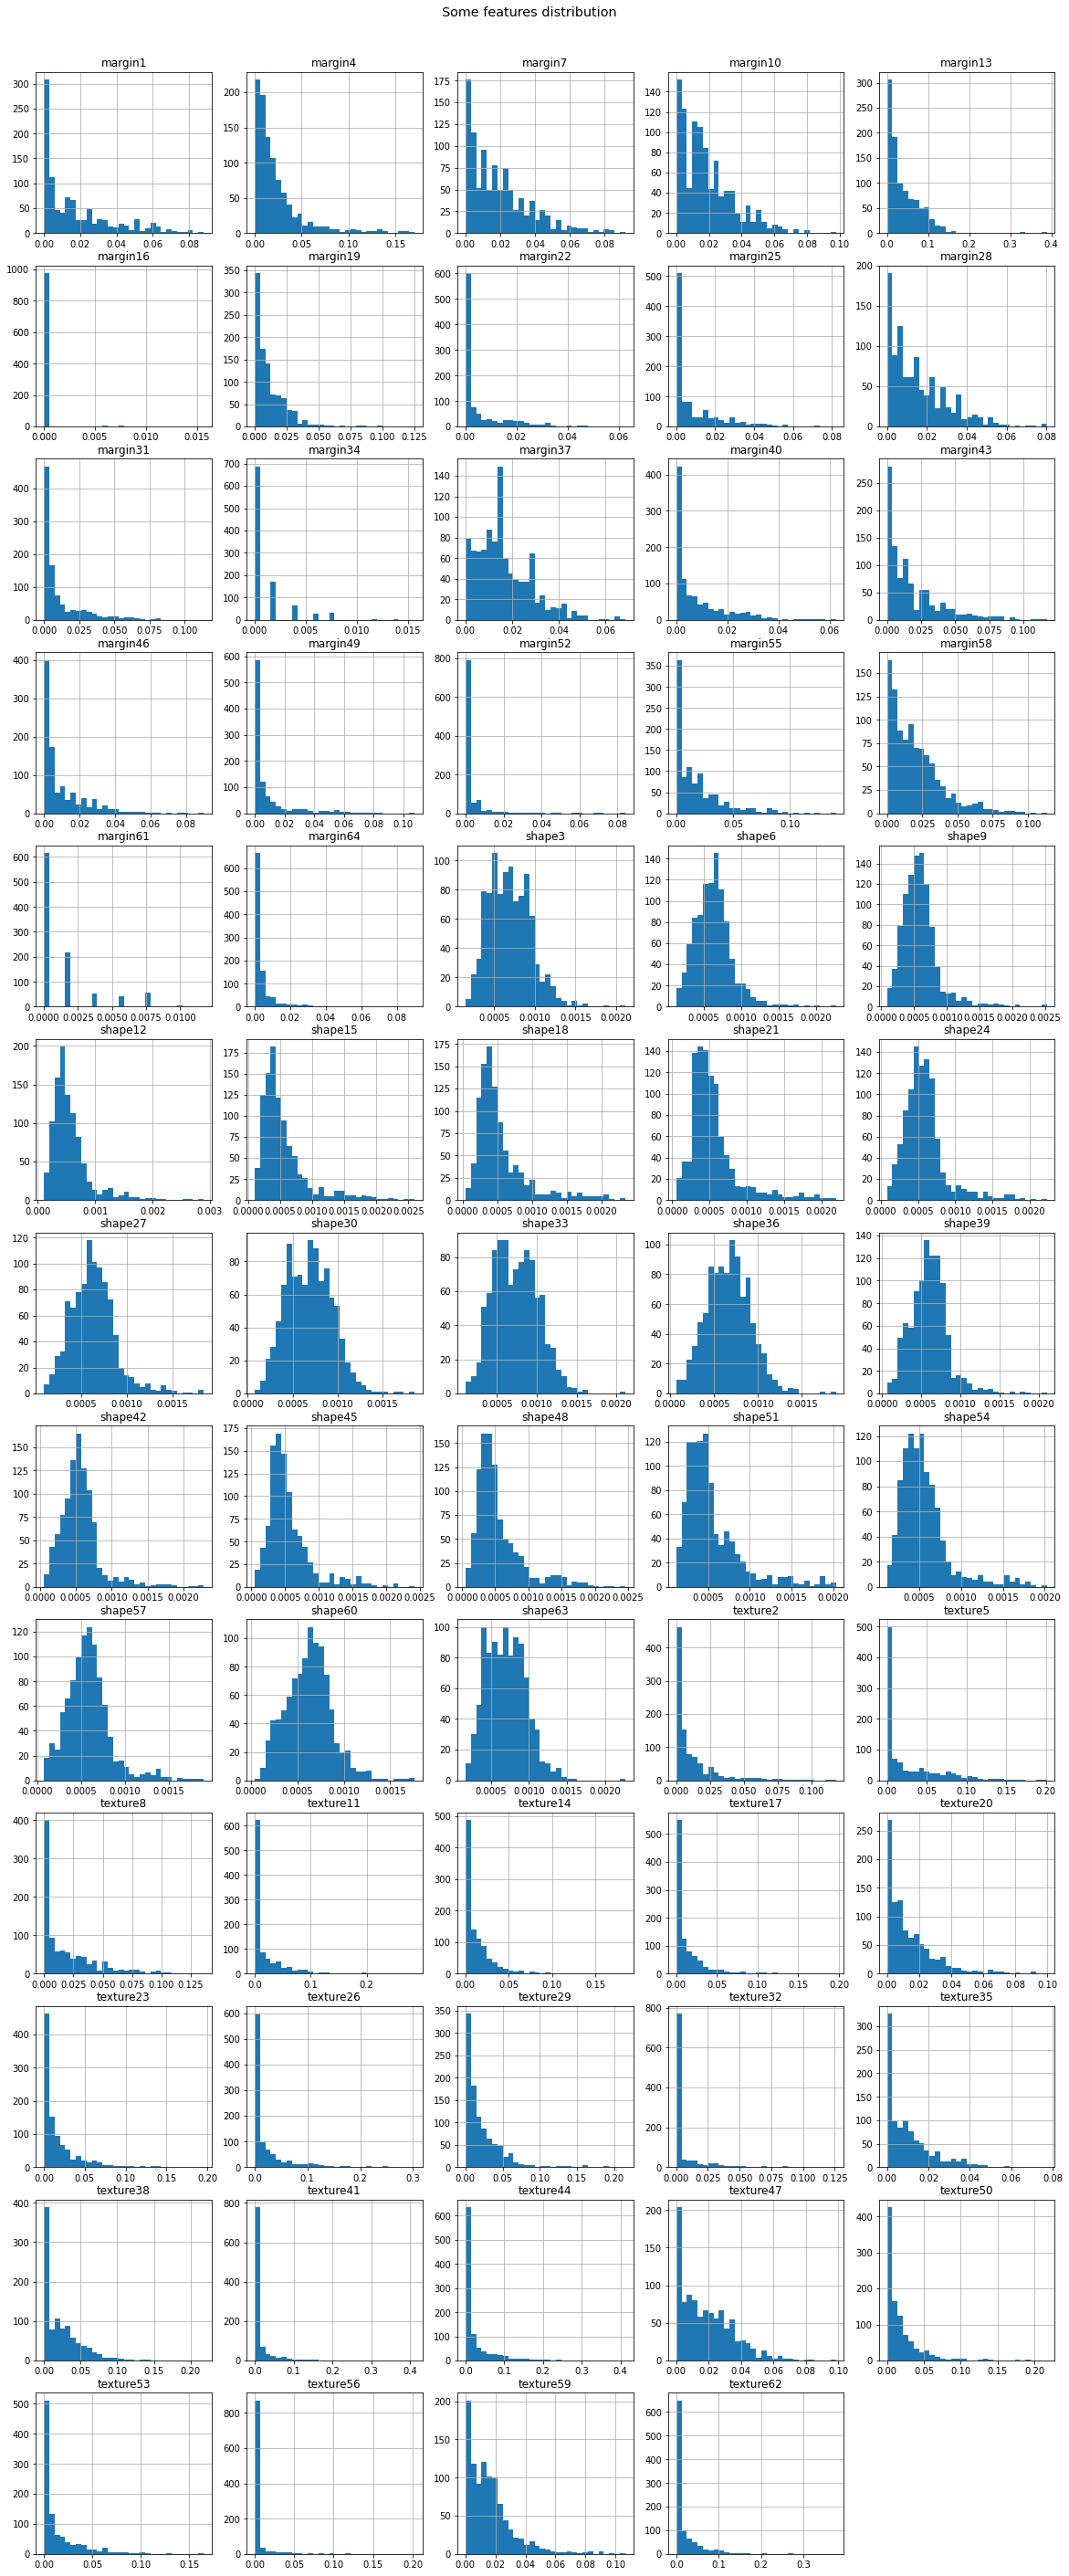

In [15]:
ncols = 5
nrows = int(len(fs)/ncols) + 1
plt.figure(figsize=(20, ncols*10))
st = plt.suptitle("Some features distribution", fontsize="x-large")

for n, feature in enumerate(fs):
    plt.subplot(nrows, ncols, n+1)
    plt.hist(train[feature].values, bins=30)
    plt.grid()
    plt.title(feature)
st.set_y(0.9)
plt.show()

In [16]:
"species" in train.columns

True

In [17]:
"species" in test.columns

False

In [18]:
all_ids = sorted(train.id.values.tolist() + test.id.values.tolist())

# Images

In [19]:
from skimage import io

In [21]:
os.listdir(dataset_dir)

['resize_image',
 'center_resize_image',
 'submissions',
 'test.csv',
 'images',
 'shapes.csv',
 'train.csv']

In [22]:
os.listdir(dataset_dir+"/images")[::60]

['1121.jpg',
 '1215.jpg',
 '1323.jpg',
 '431.jpg',
 '933.jpg',
 '1324.jpg',
 '577.jpg',
 '1230.jpg',
 '1577.jpg',
 '254.jpg',
 '1423.jpg',
 '1298.jpg',
 '625.jpg',
 '2.jpg',
 '1450.jpg',
 '914.jpg',
 '338.jpg',
 '212.jpg',
 '1049.jpg',
 '538.jpg',
 '1309.jpg',
 '314.jpg',
 '78.jpg',
 '1495.jpg',
 '1182.jpg',
 '641.jpg',
 '721.jpg']

In [24]:
train_images = {i:io.imread(dataset_dir+"/images/"+str(i)+".jpg") for i in train.id.values}
all_images = {i:io.imread(dataset_dir+"/images/"+str(i)+".jpg") for i in all_ids}

In [25]:
idx = train.id.sample(1).values[0]
idx

1201

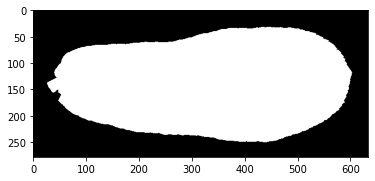

In [26]:
plt.imshow(train_images[idx], cmap="Greys_r")

In [27]:
train_images[idx].shape

(278, 634)

In [28]:
id_per_specie = train.groupby("species").first().id.values

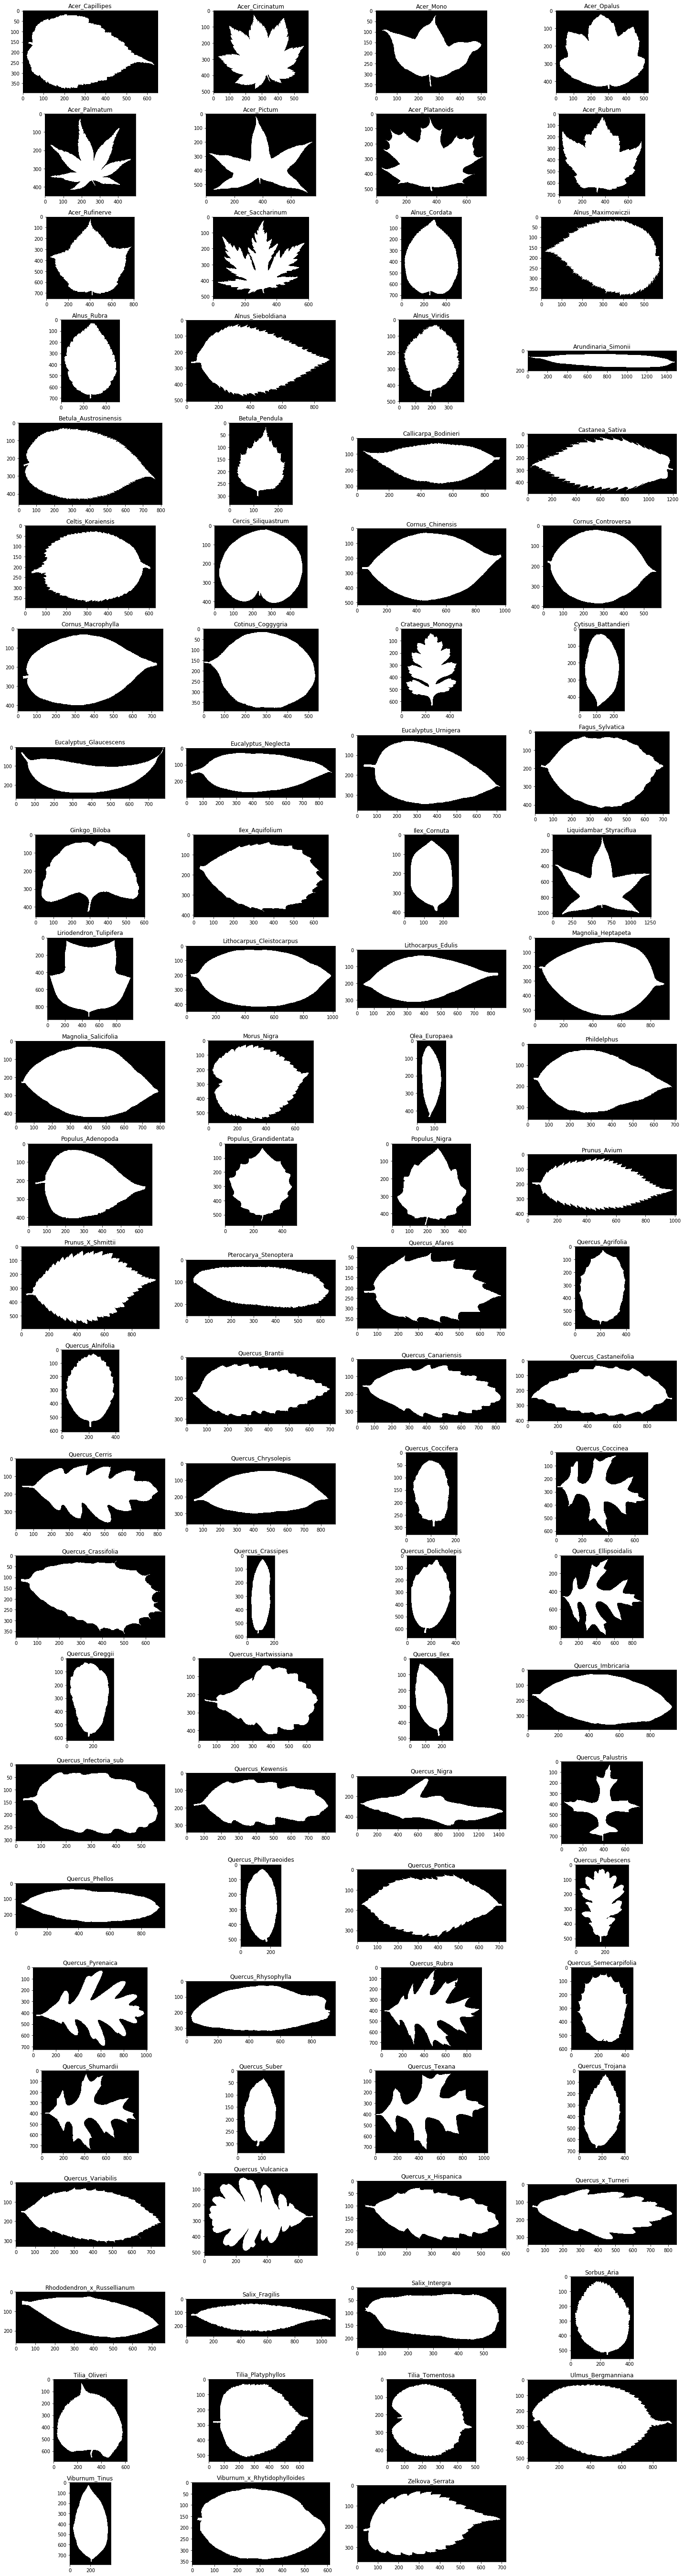

In [23]:
ncols = 4
nrows = int(num_classes/ncols)+1

plt.figure(figsize=(20, nrows*3))

for n, idx in enumerate(id_per_specie):
    plt.subplot(nrows, ncols, n+1)
    plt.imshow(train_images[idx], cmap="Greys_r")
    plt.title(train[train.id==idx].species.values[0])
    plt.tight_layout()
#plt.show()

### Image with different sizes

In [29]:
image_shapes = [all_images[i].shape for i in all_images]
ids_shapes = [i for i in all_images]

len(image_shapes)

1584

Text(0.5, 1.0, 'image shape distribution')

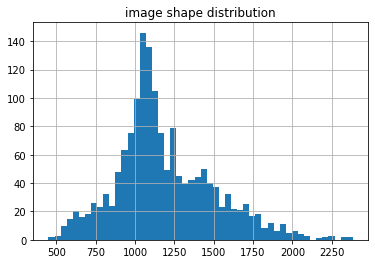

In [30]:
plt.hist([np.sum(i) for i in image_shapes], bins=50);
plt.grid()
plt.title("image shape distribution")

In [31]:
maxid = np.argmax([np.sum(i) for i in image_shapes])
minid = np.argmin([np.sum(i) for i in image_shapes])

In [32]:
maxid = ids_shapes[maxid]
minid = ids_shapes[minid]

In [33]:
big_image = all_images[maxid]
small_image = all_images[minid]

Text(0.5, 1.0, 'image shape: (264, 185)')

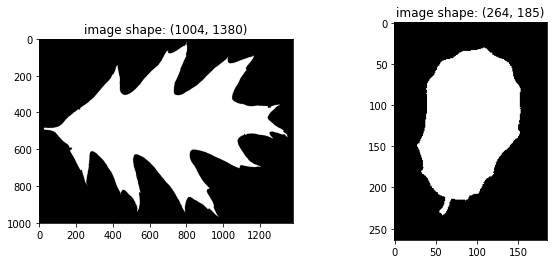

In [34]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(big_image, cmap="Greys_r")
plt.title("image shape: {}".format(big_image.shape))
plt.subplot(122)
plt.imshow(small_image, cmap="Greys_r")
plt.title("image shape: {}".format(small_image.shape))

### resize images?

Text(0.5, 1.0, 'image shape: (100, 100)')

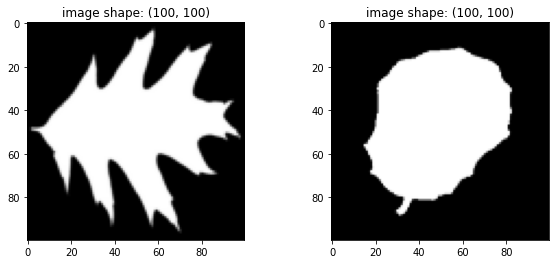

In [35]:
rbi = resize(big_image, (100, 100))
rsi = resize(small_image, (100, 100))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(rbi, cmap="Greys_r")
plt.title("image shape: {}".format(rbi.shape))
plt.subplot(122)
plt.imshow(rsi, cmap="Greys_r")
plt.title("image shape: {}".format(rsi.shape))

### center images?

In [36]:
max_size = np.max(big_image.shape)
max_size

1380

In [37]:
img = train_images[1]

In [38]:
def centering_image(img, max_size):
    
    template = np.zeros((max_size, max_size))
    w = img.shape[0]
    h = img.shape[1]
    
    c = int(max_size/2)
    
    x1 = int(c - (w/2))
    x2 = int(c + (w/2))

    y1 = int(c - (h/2))
    y2 = int(c + (h/2))
    
    template[x1:x2,y1:y2] = img
    
    return template.astype("uint8")

Text(0.5, 1.0, 'image shape: (128, 128)')

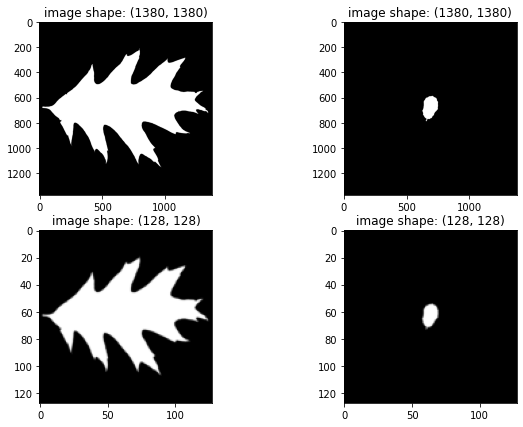

In [39]:
cbi = centering_image(big_image, max_size)
csi = centering_image(small_image, max_size)

rcbi = resize(cbi, (128, 128))
rcsi = resize(csi, (128, 128))

plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(cbi, cmap="Greys_r")
plt.title("image shape: {}".format(cbi.shape))

plt.subplot(222)
plt.imshow(csi, cmap="Greys_r")
plt.title("image shape: {}".format(csi.shape))

plt.subplot(223)
plt.imshow(rcbi, cmap="Greys_r")
plt.title("image shape: {}".format(rcbi.shape))

plt.subplot(224)
plt.imshow(rcsi, cmap="Greys_r")
plt.title("image shape: {}".format(rcsi.shape))

In [40]:
print(train[train.id==maxid].species.iloc[0], "leaf size: 20cm")
print(train[train.id==minid].species.iloc[0], "leaf size: 1.5-5cm")

Quercus_Rubra leaf size: 20cm
Quercus_Coccifera leaf size: 1.5-5cm


**Source:** <br/>
**[1]** [Quercus rubra](http://www.tree-guide.com/northern-red-oak) <br/>
**[2]** [Quercus coccifera](http://www.arbolapp.es/en/species/info/quercus-coccifera/)

## ~Preparing images~
The data downloaded in the notebook `01 - Get data` is already prepared.

In [49]:
#all_images = {i:io.imread(data_dir+"/images/"+str(i)+".jpg") for i in all_ids}

In [41]:
#max_size = np.max([np.max([all_images[i].shape[0], all_images[i].shape[1]]) for i in all_images]) + 2
#max_size

In [51]:
#train_images = {i:io.imread(data_dir+"/images/"+str(i)+".jpg") for i in train.id.values}

In [52]:
#if not os.path.exists(data_dir+"/center_resize_image/"):
#    os.makedirs(data_dir+"/center_resize_image/")
    
#if not os.path.exists(data_dir+"/resize_image/"):
#    os.makedirs(data_dir+"/resize_image/")

In [66]:
#for imgi in all_ids:
    
#    rimg = io.imread(data_dir+"/images/"+str(imgi)+".jpg")
#    rimg = centering_image(rimg, max_size)
#    rimg = resize(rimg, (128, 128))   
#    io.imsave(fname=data_dir+"/center_resize_image/"+str(imgi)+".jpg", arr=rimg, check_contrast=False)
    
#    rimg = io.imread(data_dir+"/images/"+str(imgi)+".jpg")
#    rimg = resize(rimg, (128, 128))
#    io.imsave(fname=data_dir+"/resize_image/"+str(imgi)+".jpg", arr=rimg, check_contrast=False)

## Centering examples

In [58]:
prepare_images = {i:io.imread(data_dir+"/center_resize_image/"+str(i)+".jpg") for i in train.id.values}

In [59]:
id_per_specie = train.groupby("species").first().id.values

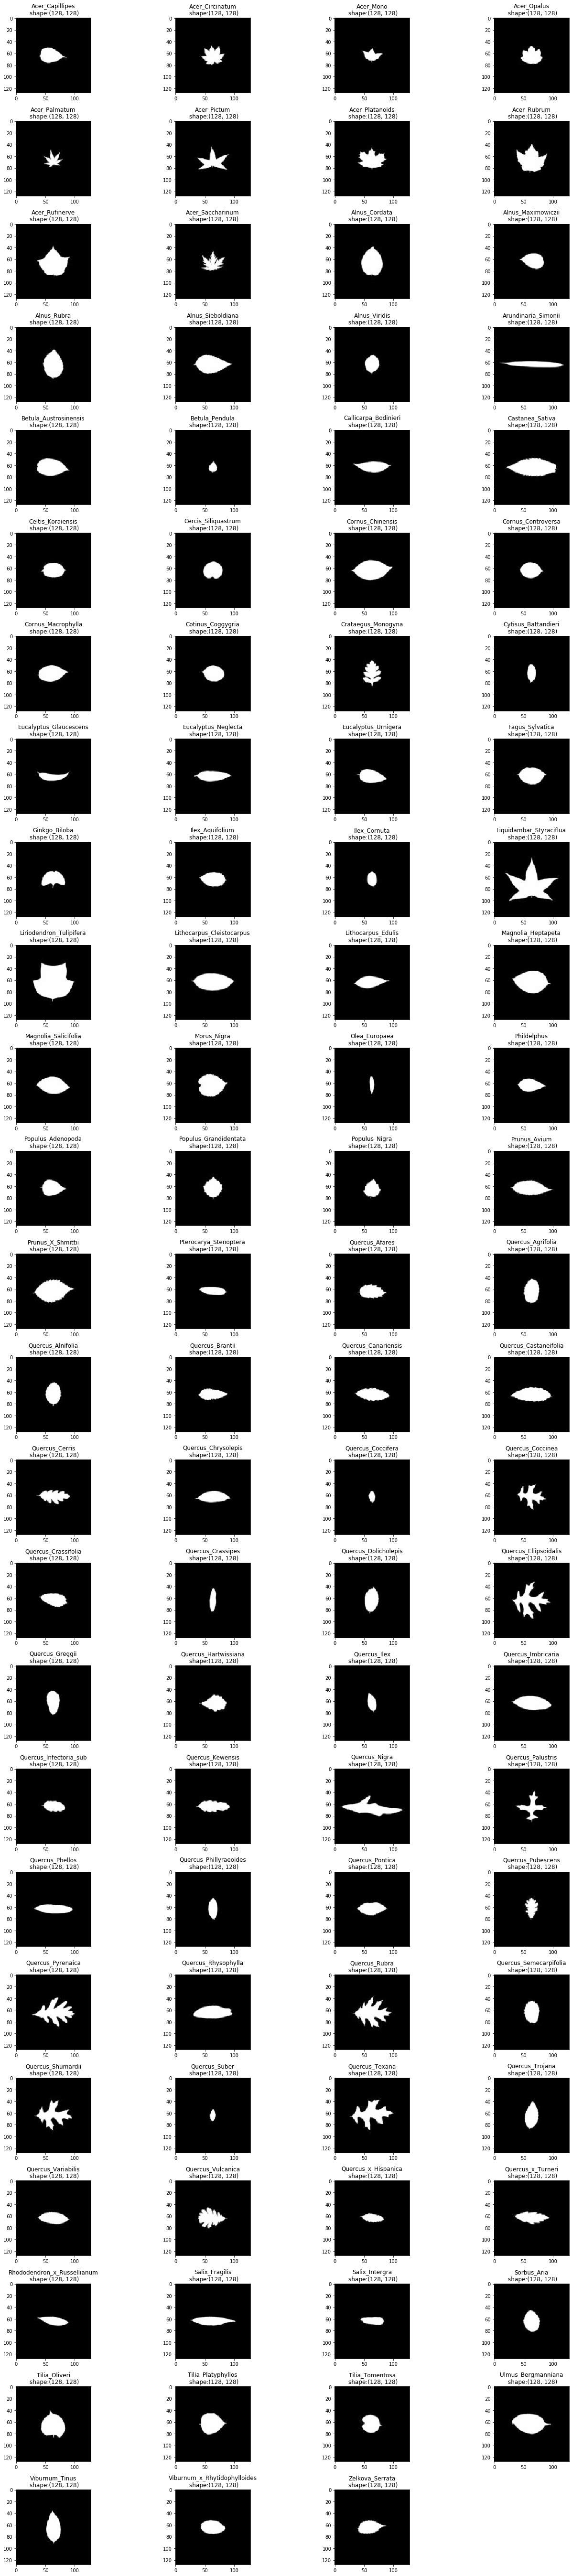

In [60]:
ncols = 4
nrows = int(num_classes/ncols)+1

plt.figure(figsize=(20, nrows*3))

for n, idx in enumerate(id_per_specie):
    plt.subplot(nrows, ncols, n+1)
    plt.imshow(prepare_images[idx], cmap="Greys_r")
    plt.title(train[train.id==idx].species.values[0]+"\n shape:"+str(prepare_images[idx].shape))
    plt.tight_layout()
#plt.show()

## Resize examples

In [61]:
prepare_images = {i:io.imread(data_dir+"/resize_image/"+str(i)+".jpg") for i in train.id.values}

In [62]:
id_per_specie = train.groupby("species").first().id.values

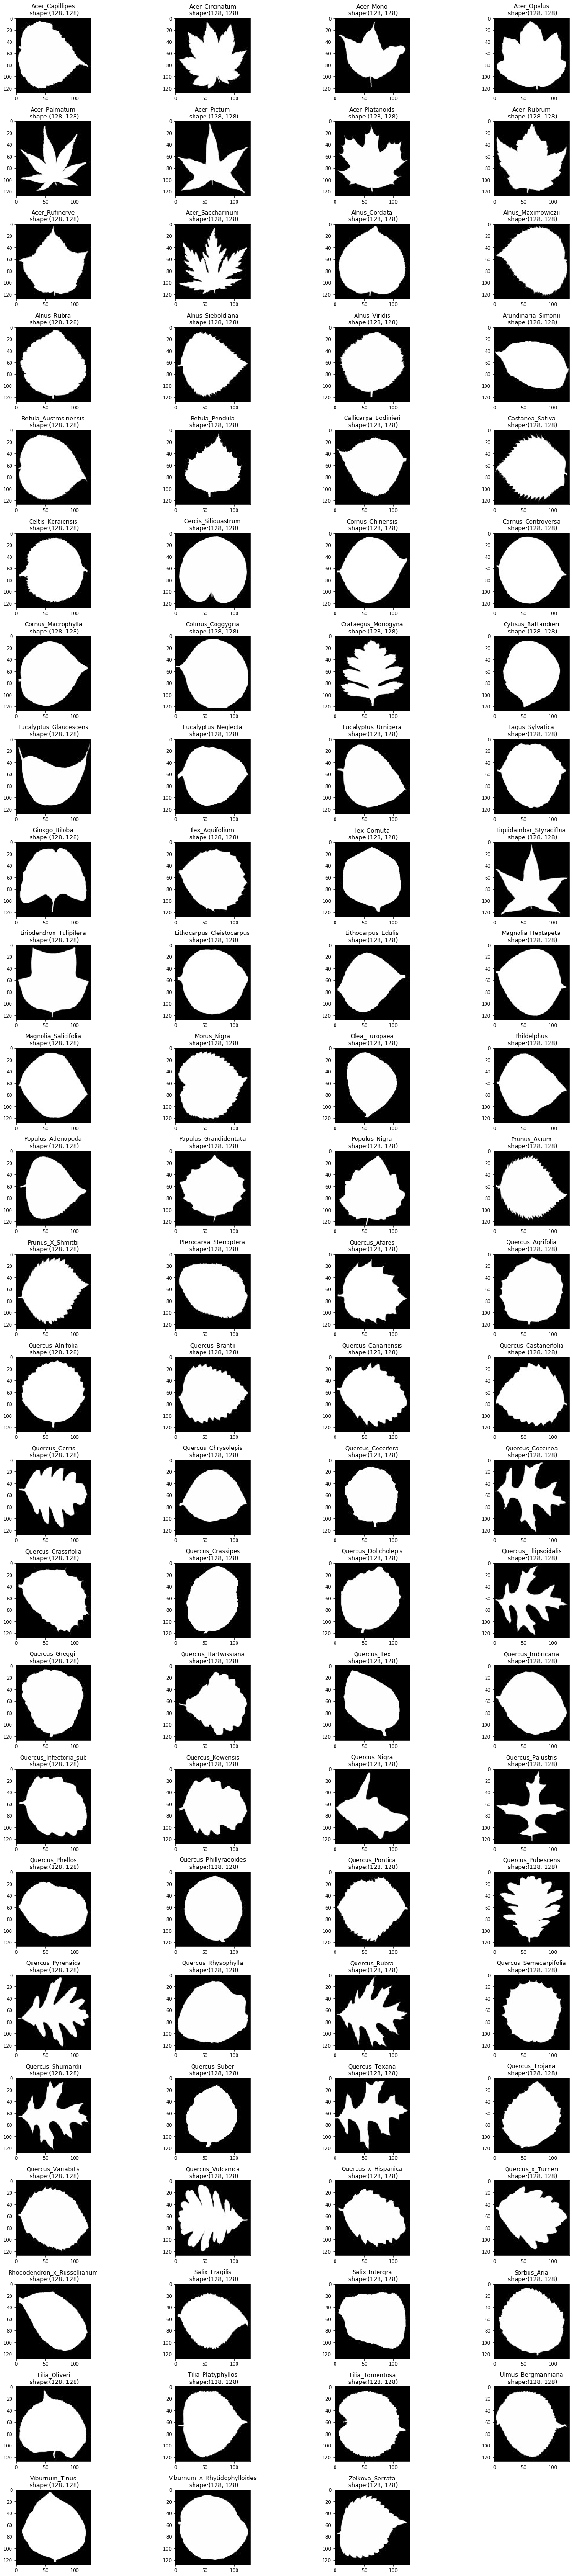

In [63]:
ncols = 4
nrows = int(num_classes/ncols)+1

plt.figure(figsize=(20, nrows*3))

for n, idx in enumerate(id_per_specie):
    plt.subplot(nrows, ncols, n+1)
    plt.imshow(prepare_images[idx], cmap="Greys_r")
    plt.title(train[train.id==idx].species.values[0]+"\n shape:"+str(prepare_images[idx].shape))
    plt.tight_layout()
#plt.show()

## original shape like feaure

In [44]:
shape_data = [[i, all_images[i].shape[0],  all_images[i].shape[1]] for i in all_images]
shape_data = pd.DataFrame(shape_data, columns=["id", "image_height", "image_width"])

In [45]:
shape_data.head()

,id,image_height,image_width
0,1,467,526
1,2,251,667
2,3,456,691
3,4,594,383
4,5,466,505


### normalize shapes data

In [46]:
minh = shape_data.image_height.min()
maxh = shape_data.image_height.max()

minw = shape_data.image_width.min()
maxw = shape_data.image_width.max()

In [47]:
shape_data.image_height = (shape_data.image_height - minh)/(maxh - minh)
shape_data.image_width = (shape_data.image_width - minw)/(maxw - minw)

## ~save shapes features~
The data downloaded in the notebook `01 - Get data` is already prepared.

In [48]:
#shape_data.to_csv(data_dir+"/shapes.csv")

**Note:** We have to split trainset in train and validation sets to train and validate our models.